## Create a notebook to perform Cash-Karp integration for multiple coupled variables

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Define our coupled derivatives to integrate

In [ ]:
def dydx(x, f):
    #set the derivatives
    
    #our equation is d^2y/dx^2 = -y
    
    #so we can write
    #dydx = z
    #dzdx = -y
    
    y = f[0]
    z = f[1]    #I don't get this fully
    
    #declare an array
    y_derivs = np.zeros_like(f) #this requires _like because of its feature of giving actual values of 0 rather than system os based nulls
    
    #set dydx = z
    y_derivs[0] = z
    
    #set dzdx = -y
    y_derivs[1] = -1*y
    
    #here we have to return the array
    return y_derivs

## Define the Cash-Karp core function

In [ ]:
def cash_karp_core_mv(dydx, xi, yi, nv, h):
    
    #declare k# arrays (what are these? https://www.researchgate.net/profile/Proceso-Fernandez/publication/316007527/figure/fig1/AS:482085128413184@1491949459014/Butcher-Tableau-for-Cash-Karp.png)
    kr = 7 #Row of 7
    kc = 6 #Column of 6
    
    #declare the array for each section (Left of the vertical line, centre stage, or below the horizontal line)
    l = np.zeros(kr)
    c1 = np.zeros((kr, kc))
    b1 = np.zeros(kr)
    b2 = np.zeros(kr)
    
    #First part - Left of the verticle line (l) (0, 1/5, 3/10, 3/5, 1, 7/8)
    l[1] = 1./5. #l[0] is ignored because it is already 0
    l[2] = 3./10.
    l[3] = 3./5.
    l[4] = 1.
    l[5] = 7./8.
    
    #Second part - Centre stage:
    
        #Column 1 (0, 1/5, 3/40, 3/10, -11/54, 1631/55296):
    c1[2,1] = 1./5. #[0, 1; #] are ignored because 1 is 0 and we will iterate according to non-array rules i.e. 1-># not 0->#
    c1[3,1] = 3./40.
    c1[4,1] = 3./10.
    c1[5,1] = -11./54.
    c1[6,1] = 1631./55296.
    
        #Column 2 (0, 9/40, -9/10, 5/2, 175/512):
    c1[3,2] = 9./40.
    c1[4,2] = -9./10.
    c1[5,2] = 5./2.
    c1[6,2] = 175./512.
    
        #Column 3 (0, -70/27, 575/13824):
    c1[4,3] = 6/5
    c1[5,3] = -70/27
    c1[6,3] = 575./13824.

        #Column 4 (0, 35/27, 44275/110592):
    c1[5,4] = 35./27.
    c1[6,4] = 44275./110592.
    
        #Column FINAL (0, 253/4096):
    c1[6,5] = 253./4096.
    
    ## The final column, just as the others, is already set to 0 ##
    
    #Third part - Lower stage:
    
        #Row 1 (37/378, 0, 250/621, 125/594, 0, 512/1771):
    b1[1] = 37./378.
    b1[2] = 0.
    b1[3] = 250./621.
    b1[4] = 125./594.
    b1[5] = 0.
    b1[6] = 512./1771.
    
        #Row 1 (2825/27648, 0, 18575/48384, 13525/55296, 277/14336, 1/4):
    b2[1] = 2825./27648.
    b2[2] = 0.
    b2[3] = 18575./48384.
    b2[4] = 13525./55296.
    b2[5] = 277./14336.
    b2[6] = 1./4.
    
    
    #define the k array
    ki = np.zeros((kr,nv)) #Create an 2D array for values along the Butcher Tableau for the Cash-Karp method along the length of the function
    

    #compute ki
    for i in range(1, kr): #Iterating through each column or the value of each row depending on the given column
        xn = xi + l[i]*h #****Iterate through values of x such that it corresponds with the given array value on the Left hand side of the verticle line
        
        yn = yi.copy() #****y values need to be reset each loop
        for j in range(1, i):
            yn += c1[i, j]*ki[j,:] #This line tells yn to add to itself (set before to be the initial y value given) the array value for each column
            
        ki[i,:] = h*dydx(xn, yn) #we are multiplying the function dydx (done previously) by the initial step value "h"
        
    #
    ynpo = yi.copy()
    ynpos = yi.copy()
    
    for i in range(1, kr): #this section iterates through the rows and gets the difference of the fourth and firth order solutions for Cash-Karp
        ynpo += b1[i] * ki[i,:] #The first is the fourth order and the second is the fifth order
        ynpos += b2[i] * ki[i,:] #in this section I used trial and error to find that the lower section gave values of are fourth and fifth order solutions, I got these from https://en.wikipedia.org/wiki/Cash%E2%80%93Karp_method
        #These are needed to get an error value "Delta"
        
    #getting the error
    Delta = np.fabs(ynpo-ynpos)
    
    return ynpo, Delta

## Define an adaptive step size drive for Cash-Karp

In [162]:
def cash_karp_mv_ad(dydx, xi, yi, nv, h, tol): #This code is pretty much all from the RK MV Method
    
    #define safety scale
    SAFETY    = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterations
    imax = 1000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv, 2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        #We need to get the return values of the function cash_karp_core_mv()
        yipo, Delta = cash_karp_core_mv(dydx, xi, yi, nv, h_step) #Delta is the main value that we want, because that's what defines the new step value
        
        #if the error is too large, take a smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check the iteration
        if (i >= imax):
            print("Too many iterations in cash_karp_mv_ad()")
            raise StopIteration("Ending after i = ", i)
            
        #iterate
        i += 1
        
    #next time we should try to make a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we actually took
    return yipo, h_new, h_step

## Define a wrapper for Cash-Karp

In [163]:
def cash_karp_mv(dfdx, a, b, y_a, tol): #Most of this code was from the RK mv program as well
    
    #dfdx is the derivative with respect to x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very teeny weeny!
    h = 1.0e-4 * (b-a)
    
    #set a maximum number of iterations
    imax = 1000
    
    #set an iteration variable
    i = 0
    
    #set the number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the intial conditions
    x = np.full(1, a)
    y = np.full((1, nv), y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = cash_karp_mv_ad(dydx, xi, yi, nv, h, tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi + h_step > b):
            #take a smaller step
            h = b - xi
            
            #recalculate y_i + 1
            yi_new, h_new, h_step = cash_karp_mv_ad(dydx, xi, yi, nv, h, tol) #This one here uses the new value of "h" (the step value)
            
            #break
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new.copy() #there might be an issue here
        
        #add the step to the arrays
        x = np.append(x, xi)
        yi_new = np.zeros((len(x), nv))
        yi_new[0:len(x) - 1, :] = y[:]
        yi_new[-1, :] = yi[:]
        del y
        y = yi_new
        
        #prevent too many iterations
        if(i >= imax):
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ", i)
            
        #iterate
        i += 1
        
        #output some information - not that important, just took from the RK mv program
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, h_step, b)
        print(s)
        
        #break if new xi is == b
        if(xi == b):
            flag = 0
            
    #return the answer
    return x,y

## Perform the integration

[0. 0.]
[0. 1.]
i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b=6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b=6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b=6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b=6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b=6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b=6.28318531
i =  10	x = 0.64276986	h = 0.32169909	b=6.28318531
i =  11	x = 0.93739384	h = 0.29462398	b=6.28318531
i =  12	x = 1.20675386	h = 0.26936002	b=6.28318531
i =  13	x = 1.49426997	h = 0.28751611	b=6.28318531
i =  14	x = 1.76344767	h = 0.26917769	b=6.28318531
i =  15	x = 2.03076151	h = 0.26731385	b=6.28318531
i =  16	x = 2.29758389	h = 0.26682237	b=6.28318531
i =  17	x = 2.56844699	h = 0.27086310	b=6.28318531
i =  18	x = 2.84768738	h = 0.27924039	b=6.28318531
i =  19	x = 3.12869484	h = 0.28100745	b=6.28318531
i =  20	x = 3.3

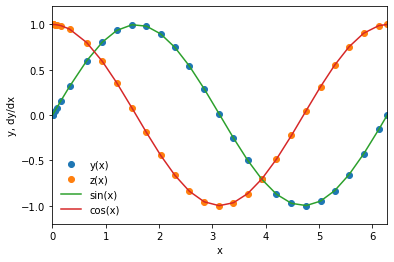

In [164]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
print(y_0) #debugging
y_0[0] = 0.0
y_0[1] = 1.0
print(y_0) #debugging
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = cash_karp_mv(dydx, a, b, y_0, tolerance)
plt.plot(x, y[:,0], 'o', label='y(x)')
plt.plot(x, y[:,1], 'o', label='z(x)')
plt.plot(x, np.sin(x), label='sin(x)')
plt.plot(x, np.cos(x), label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.xlim([0, 2*np.pi])
plt.ylim([-1.2, 1.2])
plt.legend(frameon=False)

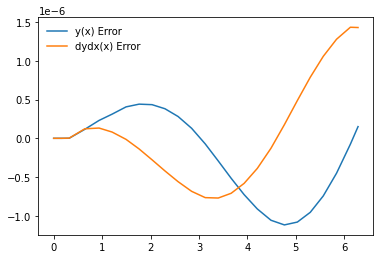

In [165]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:, 0] - sine)
dydx_error = (y[:, 1] - cosine)

plt.plot(x, y_error, label="y(x) Error")
plt.plot(x, dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)

## This was a pain to figure out, but totally worth it, hopefully I have extensive enough commen